In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [4]:
import os
print(os.listdir("../dataset/"))

['sample_submission.csv', 'test_images.npy', 'train_images.npy', 'train_labels.csv']


In [5]:
#Load images with numpy
images = np.load('../dataset/train_images.npy', encoding='bytes')
images.shape

test_images = np.load('../dataset/test_images.npy', encoding='bytes')
images.shape

(10000, 2)

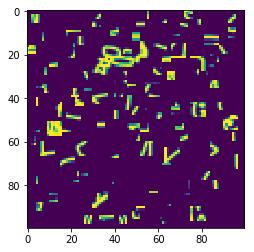

In [6]:
#Reshaping image to 100x100
image1 = (images[2][1]).reshape(100,100)
plt.imshow(image1)

In [7]:
# Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import multiprocessing
from multiprocessing.pool import ThreadPool

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2

import os

Using TensorFlow backend.


In [8]:
images = np.load('../dataset/train_images.npy', encoding="bytes")
labels = pd.read_csv('../dataset/train_labels.csv')
images.shape

(10000, 2)

In [9]:
def preProcessImageObsolete(image, cutoff=127, maxContours=5):
    image = np.uint8(image)
    im = np.uint8(image)
    red, thresh = cv2.threshold(im, cutoff, 255, 0)
    im2, contours, hierarchy= cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.uint8(np.ones(im.shape))
    largest_contours = sorted(contours, key=cv2.contourArea)

    for ind, contour in enumerate(largest_contours[maxContours:]):
        mask = cv2.drawContours(mask, [largest_contours[ind]], -1, 0, -1)
        
    filteredImage = cv2.bitwise_and(thresh, thresh, mask=mask)
    ## plt.imshow(filteredImage)
    return filteredImage

In [10]:
def preProcessImage(image, cutoff=127, maxContours=10):
    image = np.uint8(image)
    im = np.uint8(image)
    red, thresh = cv2.threshold(im, cutoff, 255, 0)
    im2, contours, hierarchy= cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(im.shape, np.uint8)
    largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for ind, contour in enumerate(largest_contours[:5]):
        x, y, w, h = cv2.boundingRect(contour)
        mask[y:y+h, x:x+w] = 255
        
    filteredImage = cv2.bitwise_and(thresh, thresh, mask=mask)
    #plt.imshow(filteredImage)
    #plt.figure()
    #plt.imshow(thresh)
    #plt.figure()
    #plt.imshow(mask)
    return filteredImage.reshape((image.shape))
    

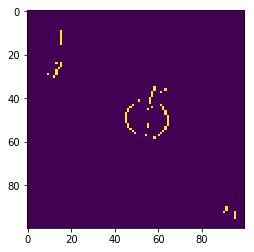

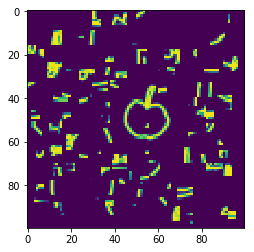

In [11]:
num = 3
image = images[num][1].reshape(100, 100)
betterImage = preProcessImage(image, 127, 5)
plt.imshow(betterImage)
plt.figure()
plt.imshow(image)

In [57]:
allData = pd.DataFrame(np.array(list(images[:,1]))).assign(label=labels['Category'])

In [58]:
num_classes = len(labels['Category'].unique())
lb = LabelBinarizer()
lb.fit(labels['Category'].unique())
valueCounts = labels['Category'].value_counts()

In [59]:
epochs = 100
batch_size = 128

In [60]:
xTrain, xValid = train_test_split(allData, stratify=labels['Category'])
trainInds = xTrain.index
validInds = xValid.index
xTrainRaw = xTrain.drop('label', axis=1).values.reshape((xTrain.shape[0], 100, 100, 1))
xValidRaw = xValid.drop('label', axis=1).values.reshape((xValid.shape[0], 100, 100, 1))

In [61]:
yTrainString = labels.iloc[trainInds, 1].values
yValidString = labels.iloc[validInds, 1].values

In [62]:
yTrain = lb.transform(yTrainString)
yValid = lb.transform(yValidString)

In [63]:
pool = ThreadPool(multiprocessing.cpu_count())
xTrain = pool.map(preProcessImage, [xTrainRaw[i] for i in range(xTrainRaw.shape[0])])
xTrain = np.array(xTrain)
xValid = pool.map(preProcessImage, [xValidRaw[i] for i in range(xValidRaw.shape[0])])
xValid = np.array(xValid)
pool.close()
pool.join()

In [2]:
num = 1
plt.imshow(xTrain[num][:,:,0])
plt.figure()
plt.imshow(xTrainRaw[num][:,:,0])
yTrainString[num]

NameError: name 'plt' is not defined

In [65]:
xTrain[10][:,:,0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [66]:
## Basic model
modelBasic = Sequential()
modelBasic.add(Dense(256, activation='relu', input_shape=(100, 100, 1)))
modelBasic.add(Dropout(0.25))

modelBasic.add(Dense(10, activation='relu'))
modelBasic.add(Dropout(0.25))
modelBasic.add(Flatten())

modelBasic.add(Dense(num_classes, activation='softmax'))
modelBasic.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics=['accuracy'])

In [67]:
## General model taken from online
model1 = Sequential()
model1.add(Conv2D(15, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(5, 5)))
model1.add(Dropout(0.25))
model1.add(Dense(10, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Flatten())
model1.add(Dense(num_classes, activation='softmax'))
model1.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics=['accuracy'])

In [68]:
## Multiple conv layers, no dropout layers

model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(10, 10)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics=['accuracy'])


In [69]:
## Multiple conv layers, no dropout layers, batch normalization

model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(10, 10)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(num_classes, activation='softmax'))
model3.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics=['accuracy'])


In [70]:
## Multiple conv layers, dropout layers, batch normalization

model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))

model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model1.add(Dropout(0.25))


model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))

model4.add(MaxPooling2D(pool_size=(10, 10)))

model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))

model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())
model4.add(Dense(num_classes, activation='softmax'))
model4.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics=['accuracy'])


In [71]:
## Multiple conv layers, dropout layers, batch normalization, average pooling

model5 = Sequential()
model5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(BatchNormalization())
model1.add(Dropout(0.25))


model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(AveragePooling2D(pool_size=(10, 10)))

model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(AveragePooling2D(pool_size=(2, 2)))

model5.add(Flatten())
model5.add(Dense(num_classes, activation='softmax'))
model5.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics=['accuracy'])


In [72]:
## Multiple conv layers, dropout layers, batch normalization, average pooling

model6 = Sequential()
model6.add(Conv2D(128, kernel_size=(15, 15), padding='same', activation='relu', input_shape=(100, 100, 1)))
model6.add(BatchNormalization(momentum=0.99, epsilon=0.00001))
model6.add(MaxPooling2D(pool_size=(10, 10), strides=(7, 7), padding='same'))

model6.add(Conv2D(256, kernel_size=(5, 5), padding='same'))
model6.add(BatchNormalization(momentum=0.99, epsilon=0.00001))
model6.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model6.add(Flatten())

model6.add(Dense(384, activation='relu'))
model6.add(Dense(192, activation='relu'))


model6.add(Dense(num_classes, activation='softmax'))
model6.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics=['accuracy'])


In [73]:
model = model6
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 100, 100, 128)     28928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 100, 128)     512       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 256)       819456    
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 15, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)             0         
__________

In [ ]:
history = model.fit(xTrain, yTrain, batch_size=batch_size,
                    epochs=epochs, verbose=1, 
                    validation_data=(xValid, yValid))

Train on 7500 samples, validate on 2500 samples
Epoch 1/100
 768/7500 [==>...........................] - ETA: 19:53 - loss: 10.0598 - acc: 0.0417